### Codigo de exploracion de datos para el analisis de predicciones de series de tiempo para planificacion de demanda

Librerias base

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
# import tensorflow as tf
# import tensorflow_probability as tfp
import seaborn as sbn
import torch


from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration
sbn.set_theme(style="ticks", color_codes=True)
viridis = cm.get_cmap('viridis', 10)

In [2]:
SOURCE = Path('/mnt/data extra/DATASET/PREDICTION_DATA')
DATA_22 = SOURCE.joinpath('unidad de medida 2022').with_suffix('.csv')
DATA_23 = SOURCE.joinpath('unidad de medida 2023').with_suffix('.csv')

## Preparacion de cargar y analizar datos modelo

Cargar y Concatenar informacion 

In [3]:
data_complete_22 = pd.read_csv(str(DATA_22),header=[0])
data_complete_22.drop(0,axis=0,inplace=True)
data_complete_23 = pd.read_csv(str(DATA_23),header=[0])
data_complete_23.drop(0,axis=0,inplace=True)
data_complete = pd.concat([data_complete_22,data_complete_23])
data_complete.reset_index(drop=True,inplace=True)
display(data_complete.head())

/tmp/ipykernel_13316/1143381664.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_complete_22 = pd.read_csv(str(DATA_22),header=[0])


,Fecha Creación,Material,Material (Cod),Peso neto (TON),Solicitate,Solicitate (Cod),Unidad Medida Base,Unidad Medida Venta,Cant Pedido UMV,Valor Neto,Contador Ped
0,1/1/2022,Cemento Fuerte Ecoplanet 50 kg,10011308.0,10.00,HECTOR QUINTANILLA BALAGUERA,0004155696,TO,SAC,200.0,"3,844.5",1
1,1/2/2022,Cemento Fuerte Ecoplanet 50 kg,10011308.0,10.00,FERRETERIA EL FERROL/ CHIQUINQUIRA,0004158888,TO,SAC,200.0,"3,939.1",1
2,1/3/2022,CEMENTO ESPECIAL PLUS (ESP+),10059053.0,34.19,PLANTA SUR CREDITO,0004151082,TO,TO,34.2,"11,863.9",1
3,1/3/2022,CEMENTO ESPECIAL PLUS (ESP+),10059053.0,33.33,PLANTA MILENIO,0004139983,TO,TO,33.3,"11,346.9",1
4,1/3/2022,CEMENTO ESPECIAL PLUS (ESP+),10059053.0,33.61,PLANTA NEREIDAS CREDITO,0004150188,TO,TO,33.6,"11,662.7",1


Seleccion de columnas

In [4]:
SELECT_COLUMNS = ['Fecha Creación','Material (Cod)','Peso neto (TON)','Solicitate (Cod)','Cant Pedido UMV','Valor Neto']
data_complete = data_complete[SELECT_COLUMNS]
display(data_complete.head())

,Fecha Creación,Material (Cod),Peso neto (TON),Solicitate (Cod),Cant Pedido UMV,Valor Neto
0,1/1/2022,10011308.0,10.00,0004155696,200.0,"3,844.5"
1,1/2/2022,10011308.0,10.00,0004158888,200.0,"3,939.1"
2,1/3/2022,10059053.0,34.19,0004151082,34.2,"11,863.9"
3,1/3/2022,10059053.0,33.33,0004139983,33.3,"11,346.9"
4,1/3/2022,10059053.0,33.61,0004150188,33.6,"11,662.7"


Conversion de tipos de datos

In [4]:
data_complete.dtypes

Fecha Creación          object
Material                object
Material (Cod)         float64
Peso neto (TON)        float64
Solicitate              object
Solicitate (Cod)        object
Unidad Medida Base      object
Unidad Medida Venta     object
Cant Pedido UMV         object
Valor Neto              object
Contador Ped            object
dtype: object

In [6]:
data_complete

,Fecha Creación,Material (Cod),Peso neto (TON),Solicitate (Cod),Cant Pedido UMV,Valor Neto
0,1/1/2022,10011308.0,10.000,0004155696,200.0,"3,844.5"
1,1/2/2022,10011308.0,10.000,0004158888,200.0,"3,939.1"
2,1/3/2022,10059053.0,34.190,0004151082,34.2,"11,863.9"
3,1/3/2022,10059053.0,33.330,0004139983,33.3,"11,346.9"
4,1/3/2022,10059053.0,33.610,0004150188,33.6,"11,662.7"
...,...,...,...,...,...,...
105666,3/27/2023,10011308.0,34.500,4125819.0,690.0,"14,974.4"
105667,3/27/2023,10011308.0,35.500,4125819.0,710.0,"15,408.4"
105668,3/27/2023,10011309.0,34.000,4171362.0,"3,200.0","45,146.9"
105669,3/27/2023,10011309.0,35.020,4171362.0,"2,472.0","34,876.0"


In [7]:
format = '%m/%d/%Y'
data_complete['Fecha Creación']=pd.to_datetime(data_complete['Fecha Creación'], format=format)
data_complete['Material (Cod)'] = data_complete['Material (Cod)'].apply(lambda x: np.int32(x))
# data_complete['Peso neto (TON)'] = data_complete['Peso neto (TON)'].apply(lambda x: np.float(x))
data_complete['Solicitate (Cod)'] = data_complete['Solicitate (Cod)'].apply(lambda x: str(x))                                                          
data_complete['Cant Pedido UMV'] = data_complete['Cant Pedido UMV'].apply(lambda x: float(x.replace(',','')))
data_complete['Valor Neto'] = data_complete['Valor Neto'].apply(lambda x: float(x.replace(',','')))

Cambio de nombre

In [8]:
old = data_complete.columns
new = ['FECHA','MATERIAL','PESO','COMPRADOR','CANTIDAD','VALOR']
data_complete.rename(columns={old_:new_ for old_,new_ in zip(old,new)},inplace=True)
display(data_complete.head())

,FECHA,MATERIAL,PESO,COMPRADOR,CANTIDAD,VALOR
0,2022-01-01,10011308,10.00,0004155696,200.0,3844.5
1,2022-01-02,10011308,10.00,0004158888,200.0,3939.1
2,2022-01-03,10059053,34.19,0004151082,34.2,11863.9
3,2022-01-03,10059053,33.33,0004139983,33.3,11346.9
4,2022-01-03,10059053,33.61,0004150188,33.6,11662.7


In [9]:
data_complete.dtypes

FECHA        datetime64[ns]
MATERIAL              int32
PESO                float64
COMPRADOR            object
CANTIDAD            float64
VALOR               float64
dtype: object

Correcion de la columan de datos de compra para el uso de para cuantificar bien el ID del Comprador por dia

In [10]:
fix_buyer = []
for index,buyer in enumerate(data_complete.COMPRADOR):
    try:
        fix_buyer.append(str(int(buyer)))
    except:
        
        try:
            fix_buyer.append(str(int(float(buyer))))

        except:
            fix_buyer.append(str(buyer))
        
        
data_complete.COMPRADOR = fix_buyer
display("Lista de compradores")
display(pd.DataFrame(data_complete.COMPRADOR.value_counts()))

'Lista de compradores'

,COMPRADOR
4102523,3822
4177452,1452
4169882,1431
4177659,1275
4103801,1156
...,...
4180340,1
4181290,1
4183823,1
4181287,1


Numero de materiales que dispone la empresa y cantidad de apariciones de datos a lo largo de 2 anos, con una distribucion de tiempo por dia 

In [11]:
cantidad_materiales = pd.DataFrame(data_complete.MATERIAL.value_counts())
display(cantidad_materiales)

,MATERIAL
10011308,38588
10070707,14130
10059053,6515
10011306,5935
10011305,2315
...,...
96044601,1
96018785,1
96018801,1
96018813,1


Separacion de los datos en otras distancia de series de tiempo

In [12]:
#Cambio de indice
data_complete['Dia'] = data_complete.FECHA.dt.day
data_complete['Mes'] = data_complete.FECHA.dt.month
data_complete['Año'] = data_complete.FECHA.dt.year
data_complete['Semana'] = data_complete.FECHA.dt.isocalendar().week 
data_complete['DiaSemana'] = data_complete.FECHA.dt.day_of_week
display(data_complete)

,FECHA,MATERIAL,PESO,COMPRADOR,CANTIDAD,VALOR,Dia,Mes,Año,Semana,DiaSemana
0,2022-01-01,10011308,10.000,4155696,200.0,3844.5,1,1,2022,52,5
1,2022-01-02,10011308,10.000,4158888,200.0,3939.1,2,1,2022,52,6
2,2022-01-03,10059053,34.190,4151082,34.2,11863.9,3,1,2022,1,0
3,2022-01-03,10059053,33.330,4139983,33.3,11346.9,3,1,2022,1,0
4,2022-01-03,10059053,33.610,4150188,33.6,11662.7,3,1,2022,1,0
...,...,...,...,...,...,...,...,...,...,...,...
105666,2023-03-27,10011308,34.500,4125819,690.0,14974.4,27,3,2023,13,0
105667,2023-03-27,10011308,35.500,4125819,710.0,15408.4,27,3,2023,13,0
105668,2023-03-27,10011309,34.000,4171362,3200.0,45146.9,27,3,2023,13,0
105669,2023-03-27,10011309,35.020,4171362,2472.0,34876.0,27,3,2023,13,0


# Seleccion de producto y generacion de fecha

In [13]:
#Cambio de indice
PRODUCTO = 10011308
# data_complete.set_index('FECHA',inplace=True)
df = data_complete[data_complete.MATERIAL == PRODUCTO]

In [14]:
df.head()

,FECHA,MATERIAL,PESO,COMPRADOR,CANTIDAD,VALOR,Dia,Mes,Año,Semana,DiaSemana
0,2022-01-01,10011308,10.0,4155696,200.0,3844.5,1,1,2022,52,5
1,2022-01-02,10011308,10.0,4158888,200.0,3939.1,2,1,2022,52,6
14,2022-01-03,10011308,5.0,4181050,100.0,2423.4,3,1,2022,1,0
15,2022-01-03,10011308,5.0,4177946,100.0,2011.2,3,1,2022,1,0
16,2022-01-03,10011308,35.0,4122784,1400.0,23119.4,3,1,2022,1,0


In [15]:
df = df.groupby(df.FECHA).sum()
index = pd.date_range(df.index[0],df.index.max())
fill_index = pd.DataFrame([ x for x in range(len(index)) ],index=index)
df = df.reindex(fill_index.index, fill_value=0)

/tmp/ipykernel_12188/3434205304.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(df.FECHA).sum()


In [16]:
df['DIA'] = df.index.day
df['MES'] = df.index.month
df['ANO'] = df.index.year
df['SEMANA'] = df.index.isocalendar().week 
df['DIASEMANA'] = df.index.day_of_week

In [17]:
X = df[['DIA','MES','ANO','SEMANA','DIASEMANA']]
Y = df[['CANTIDAD']]

In [18]:
Y.describe()

,CANTIDAD
count,451.000000
mean,55835.226164
std,37782.714497
min,0.000000
25%,32124.500000
50%,61008.000000
75%,76732.500000
max,310201.000000


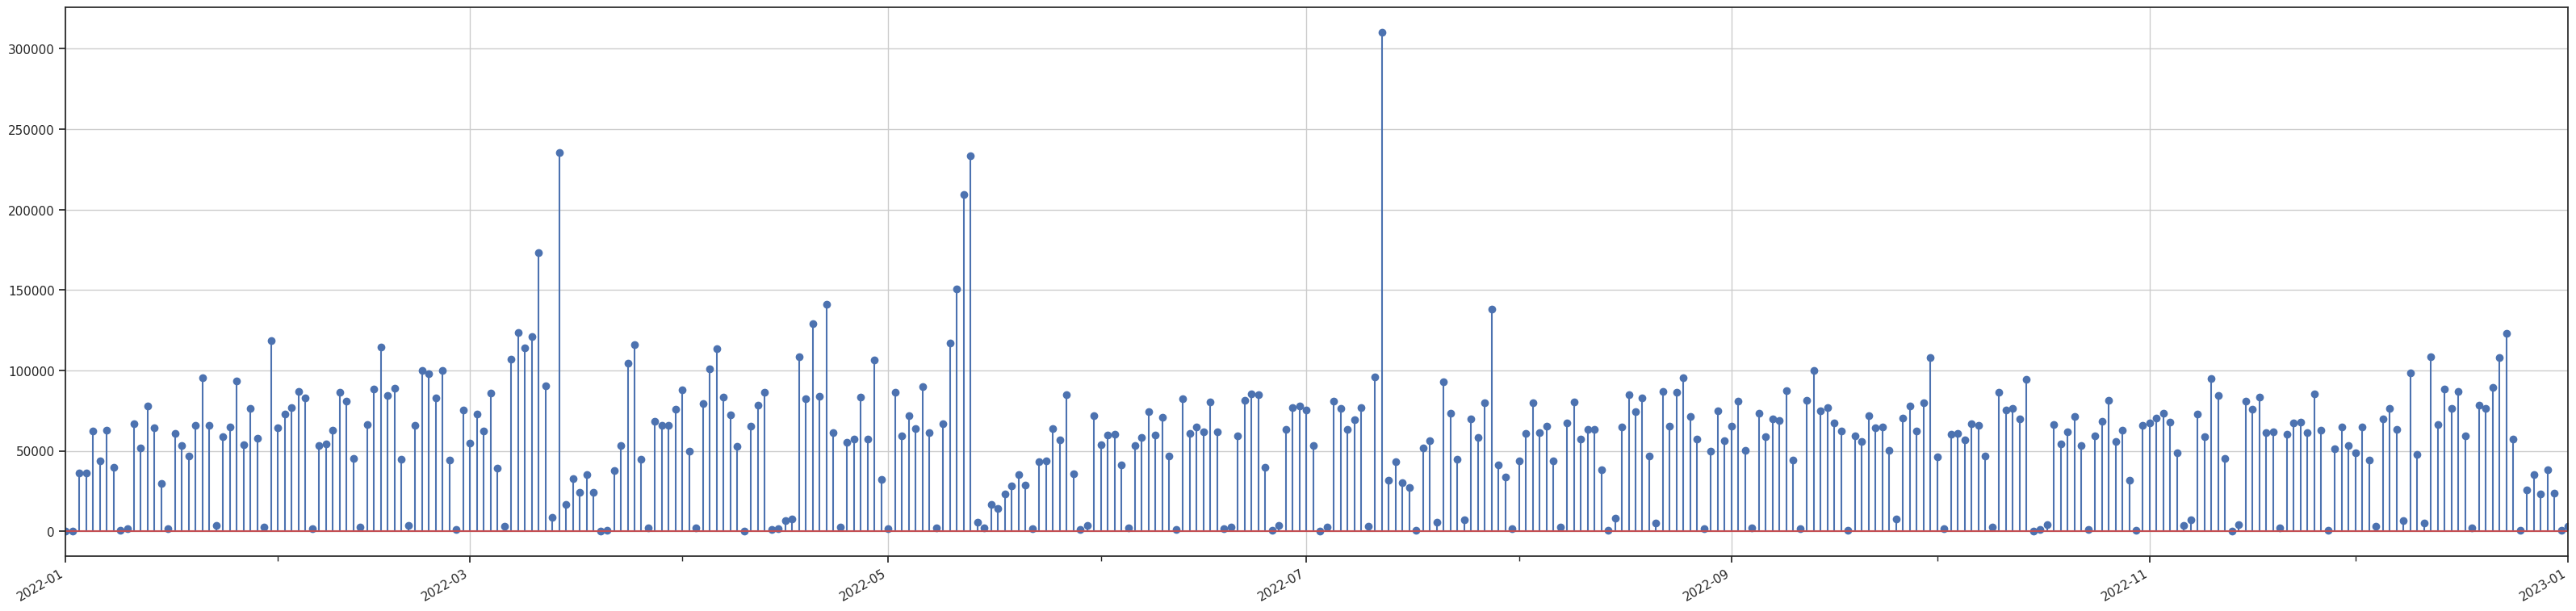

In [19]:
fig, ax = plt.subplots(figsize=(40,10))
ax.stem(df.index,df['CANTIDAD'].values)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
datemin =np.datetime64(df.index.min(), 'Y')
datemax =np.datetime64(df.index.max(), 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.show()

Agrupacon de datos por semana

In [20]:
df

,MATERIAL,PESO,CANTIDAD,VALOR,Dia,Mes,Año,Semana,DiaSemana,DIA,MES,ANO,SEMANA,DIASEMANA
2022-01-01,10011308,10.00,200.0,3844.5,1,1,2022,52,5,1,1,2022,52,5
2022-01-02,10011308,10.00,200.0,3939.1,2,1,2022,52,6,2,1,2022,52,6
2022-01-03,460520168,1028.50,36410.0,519776.2,138,46,93012,46,0,3,1,2022,1,0
2022-01-04,550621940,1214.05,36251.0,582607.6,220,55,111210,55,55,4,1,2022,1,1
2022-01-05,710802868,1315.95,62189.0,966602.1,355,71,143562,71,142,5,1,2022,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,1551752740,2937.65,100253.0,1931504.0,3565,465,313565,1860,465,23,3,2023,12,3
2023-03-24,1141289112,2103.70,74574.0,1365273.2,2736,342,230622,1368,456,24,3,2023,12,4
2023-03-25,730825484,1530.05,44131.0,807721.8,1825,219,147679,876,365,25,3,2023,12,5
2023-03-26,0,0.00,0.0,0.0,0,0,0,0,0,26,3,2023,12,6


In [27]:
data_per_weeks = df.groupby([pd.Grouper(freq='W')])['CANTIDAD'].sum()
data_per_weeks = pd.DataFrame(data_per_weeks)

data_per_weeks['MES'] = data_per_weeks.index.month
data_per_weeks['ANO'] = data_per_weeks.index.year
data_per_weeks['SEMANA'] = data_per_weeks.index.isocalendar().week 

display(data_per_weeks)

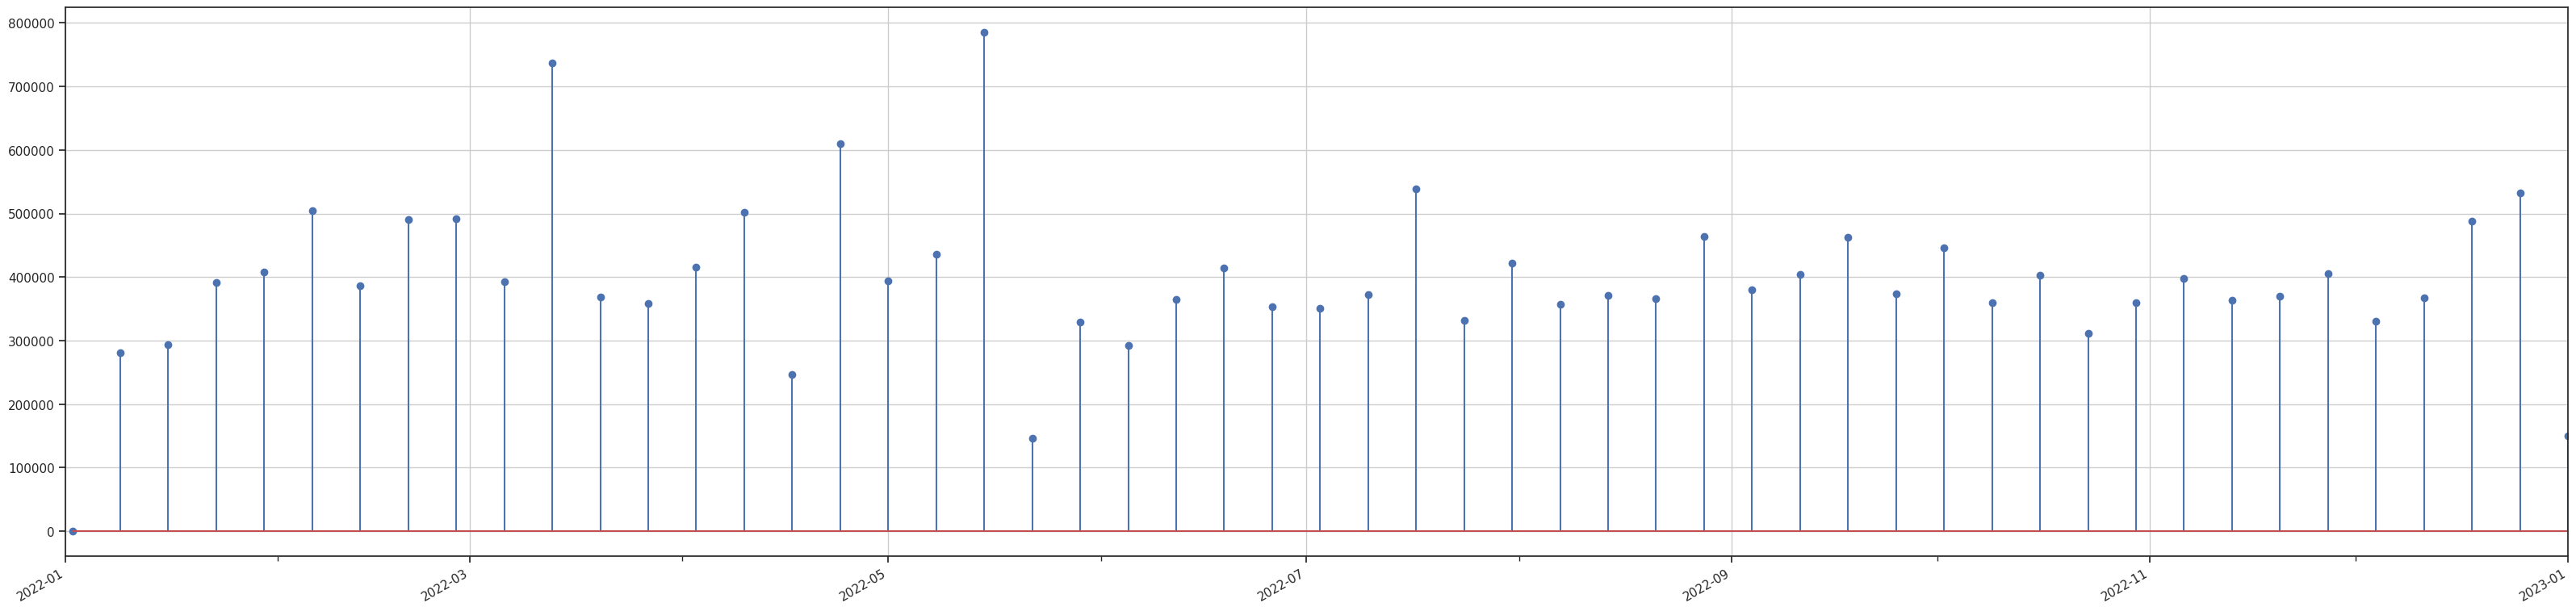

In [28]:
fig, ax = plt.subplots(figsize=(40,10))
ax.stem(data_per_weeks.index,data_per_weeks['CANTIDAD'].values)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
datemin =np.datetime64(df.index.min(), 'Y')
datemax =np.datetime64(df.index.max(), 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.show()

In [29]:
df = data_per_weeks

## Preparacion de datos para modelo

Uso de modelo de transformers

In [30]:
X = df[['MES','ANO','SEMANA']]
Y = df[['CANTIDAD']]

# X = df[['DIA','MES','ANO','SEMANA','DIASEMANA']]
# Y = df[['CANTIDAD']]


scalers = {}

encoded_material = X
for col in [column for column in encoded_material.columns]:
    scalers[col] = StandardScaler()
    encoded_material[col] = scalers[col].fit_transform(X[col].to_numpy().reshape(-1, 1))

# Normalizar la columna 'Cantidad' utilizando MinMaxScaler

scaled_cantidad = Y
scaler = StandardScaler()
scaled_cantidad['CANTIDAD'] = scaler.fit_transform(Y[['CANTIDAD']])

/tmp/ipykernel_12188/1831343310.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_material[col] = scalers[col].fit_transform(X[col].to_numpy().reshape(-1, 1))
/tmp/ipykernel_12188/1831343310.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_material[col] = scalers[col].fit_transform(X[col].to_numpy().reshape(-1, 1))
/tmp/ipykernel_12188/1831343310.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [140]:
window_size = 4

train_frac = 0.8
n_train = int(train_frac * len(df))

train_df = df.iloc[:n_train]
test_df = df.iloc[n_train:]

X_columns = ['MES', 'ANO', 'SEMANA']
y_column = 'CANTIDAD'

X_train = train_df[X_columns].values
y_train = train_df[y_column].values

X_test = test_df[X_columns].values
y_test = test_df[y_column].values

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y= StandardScaler()
Y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

def create_sliding_window_data(X, y, window_size):
    X_windowed = []
    y_windowed = []
    
    for i in range(len(X) - window_size):
        X_windowed.append(X[i:i + window_size])
        y_windowed.append(y[i + window_size])
        
    return np.array(X_windowed), np.array(y_windowed)

X_train_windowed, y_train_windowed = create_sliding_window_data(X_train_scaled, Y_train_scaled, window_size)
X_test_windowed, y_test_windowed = create_sliding_window_data(X_test_scaled, y_test_scaled, window_size)

In [31]:
# X = encoded_material
# Y = scaled_cantidad

# training_data_ratio = 0.7
# seq_length = 5
# # Calculate data count.
# data_count = len(X[: -1 - seq_length])
# # Calculate bound index.
# bound_index = int(data_count * training_data_ratio)
# # Init seqs_x, seqs_y.
# scaled_seqs_x, scaled_seqs_y = [], []
# # Scale to valid dates.


# for date_index, date in enumerate(X.index[: -1]):
#     # Continue until valid date index.
#     if date_index < seq_length:
#         continue
#     data_x, data_y = [], []
#     # for index, code in enumerate(self.state_codes):
# #         # Get scaled frame by code.
# #         scaled_frame = self.scaled_frames[code]
# #         # Get instrument data x.
#     instruments_x = X.iloc[date_index - seq_length: date_index]
#     data_x.append(np.array(instruments_x))
#     # Get instrument data y.
#     # if index < date_index - 1:
#     if date_index < bound_index:
# #                 # Get y, y is not at date index, but plus 1. (Training Set)
#         instruments_y = Y.iloc[date_index + 1]['CANTIDAD']
#     else:
#         # Get y, y is at date index. (Test Set)
#         instruments_y = Y.iloc[date_index + 1]['CANTIDAD']
#     data_y.append(np.array(instruments_y))
# #     # Convert list to array.
#     data_x = np.array(data_x)
#     data_y = np.array(data_y)
#     seq_x = []
#     seq_y = data_y
#     # Build seq x, y.
#     for seq_index in range(seq_length):
#         seq_x.append(data_x[:, seq_index, :].reshape((-1)))
#     # Convert list to array.
#     seq_x = np.array(seq_x)
#     scaled_seqs_x.append(seq_x)
#     scaled_seqs_y.append(seq_y)
# # Convert seq from list to array.
# seq_data_x = np.array(scaled_seqs_x)
# seq_data_y = np.array(scaled_seqs_y)

In [1]:
# Crear un conjunto de datos personalizado para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

dataset = TimeSeriesDataset(X_train_windowed, y_train_windowed)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

class CustomTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super().__init__()
        self.transformer = nn.Transformer(d_model, nhead, num_layers, dim_feedforward)
        self.linear = nn.Linear(d_model, 1)

    def forward(self, x):
        # Crear una máscara de atención triangular inferior para asegurar que las posiciones futuras no afecten las predicciones
        attn_mask = torch.triu(torch.ones(x.size(0), x.size(0)), diagonal=1).bool().to(x.device)
        
        # Proporcionar el mismo tensor para las entradas de origen y destino
        x = self.transformer(x, x,tgt_mask=attn_mask)
        x = self.linear(x[:, -1])
        return x

# Hiperparámetros del modelo
d_model = 3  # Cambiar esto para que coincida con la cantidad de características en tus datos
nhead = 3
num_layers = 5
dim_feedforward = 256

# Crear el modelo
model = CustomTransformer(d_model, nhead, num_layers, dim_feedforward)

# Define your execution device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 
model.to(device)    

NameError: name 'Dataset' is not defined

In [142]:
# Entrenar el modelo con tus datos (necesitarás ajustar esto a tu problema específico)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # Asegurar que los datos tienen la forma correcta (S, N, E)
        # batch_X = batch_X.transpose(0, 1)
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        # Hacer predicciones con los datos de entrada
        predictions = model(batch_X).squeeze(-1)
        
        # Calcular la pérdida
        loss = criterion(predictions, batch_y)
        
        # Optimizar el modelo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss,epoch)

/home/bdebian/.virtualenvs/predeman/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.4473, device='cuda:0', grad_fn=<MseLossBackward0>) 0
tensor(1.3093, device='cuda:0', grad_fn=<MseLossBackward0>) 1
tensor(0.4926, device='cuda:0', grad_fn=<MseLossBackward0>) 2
tensor(1.1787, device='cuda:0', grad_fn=<MseLossBackward0>) 3
tensor(0.8600, device='cuda:0', grad_fn=<MseLossBackward0>) 4
tensor(1.0645, device='cuda:0', grad_fn=<MseLossBackward0>) 5
tensor(1.1009, device='cuda:0', grad_fn=<MseLossBackward0>) 6
tensor(1.1660, device='cuda:0', grad_fn=<MseLossBackward0>) 7
tensor(1.2503, device='cuda:0', grad_fn=<MseLossBackward0>) 8
tensor(1.2285, device='cuda:0', grad_fn=<MseLossBackward0>) 9
tensor(1.2637, device='cuda:0', grad_fn=<MseLossBackward0>) 10
tensor(0.8369, device='cuda:0', grad_fn=<MseLossBackward0>) 11
tensor(1.1353, device='cuda:0', grad_fn=<MseLossBackward0>) 12
tensor(1.1082, device='cuda:0', grad_fn=<MseLossBackward0>) 13
tensor(1.1253, device='cuda:0', grad_fn=<MseLossBackward0>) 14
tensor(1.0831, device='cuda:0', grad_fn=<MseLossBackward0>) 15
te

In [143]:
torch.save(model.state_dict(), f"{PRODUCTO} trained_transformer.pth")

In [144]:
dataset = TimeSeriesDataset(X_test_windowed, y_test_windowed)
dataloader_test = DataLoader(dataset, batch_size=1, shuffle=True)

for batch_X, batch_y in dataloader_test:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        inverse_input = batch_X.cpu().detach().numpy()
        inverso_input_reshape = scaler_x.inverse_transform(inverse_input.reshape(-1,3))
        
        frame_input_inverse  = pd.DataFrame(inverso_input_reshape,columns=['MES','ANO','SEMANA'])
        display(frame_input_inverse)

        
        predictions = model(batch_X).squeeze(-1)
        
        predictions_cpu = predictions.cpu().detach().numpy()
        prediccion_inverse = scaler_y.inverse_transform(predictions_cpu.reshape(-1, 1))
        display(prediccion_inverse)

,MES,ANO,SEMANA
0,1.0,2023.0,52.0
1,1.0,2023.0,1.0
2,1.0,2023.0,2.0
3,1.0,2023.0,3.0


array([[406989.34]], dtype=float32)

,MES,ANO,SEMANA
0,2.0,2023.0,5.0
1,2.0,2023.0,6.0
2,2.0,2023.0,7.0
3,2.0,2023.0,8.0


array([[407874.22]], dtype=float32)

,MES,ANO,SEMANA
0,2.0,2023.0,8.000000
1,3.0,2023.0,9.000000
2,3.0,2023.0,10.000000
3,3.0,2023.0,10.999999


array([[407874.53]], dtype=float32)

,MES,ANO,SEMANA
0,1.0,2023.0,4.0
1,2.0,2023.0,5.0
2,2.0,2023.0,6.0
3,2.0,2023.0,7.0


array([[418463.84]], dtype=float32)

,MES,ANO,SEMANA
0,1.0,2023.0,2.0
1,1.0,2023.0,3.0
2,1.0,2023.0,4.0
3,2.0,2023.0,5.0


array([[407481.28]], dtype=float32)

,MES,ANO,SEMANA
0,3.0,2023.0,9.000000
1,3.0,2023.0,10.000000
2,3.0,2023.0,10.999999
3,3.0,2023.0,12.000000


array([[407327.16]], dtype=float32)

,MES,ANO,SEMANA
0,1.0,2023.0,1.0
1,1.0,2023.0,2.0
2,1.0,2023.0,3.0
3,1.0,2023.0,4.0


array([[373846.2]], dtype=float32)

,MES,ANO,SEMANA
0,2.0,2023.0,7.0
1,2.0,2023.0,8.0
2,3.0,2023.0,9.0
3,3.0,2023.0,10.0


array([[406702.8]], dtype=float32)

,MES,ANO,SEMANA
0,1.0,2023.0,3.0
1,1.0,2023.0,4.0
2,2.0,2023.0,5.0
3,2.0,2023.0,6.0


array([[407511.2]], dtype=float32)

,MES,ANO,SEMANA
0,2.0,2023.0,6.0
1,2.0,2023.0,7.0
2,2.0,2023.0,8.0
3,3.0,2023.0,9.0


array([[406493.9]], dtype=float32)

In [132]:
inverse_input.reshape(-1,3)

array([[-1.5801674,  1.       , -1.6324267],
       [-1.5801674,  1.       , -1.565797 ],
       [-1.5801674,  1.       , -1.4991673],
       [-1.2898186,  1.       , -1.4325377],
       [-1.2898186,  1.       , -1.365908 ]], dtype=float32)

In [121]:
scaler_x.inverse_transform(inverso_input_reshape)

array([[1.0000002e+00, 2.0230000e+03, 4.0000000e+00],
       [1.9999998e+00, 2.0230000e+03, 5.0000000e+00],
       [1.9999998e+00, 2.0230000e+03, 6.0000000e+00],
       [1.9999998e+00, 2.0230000e+03, 7.0000000e+00],
       [1.9999998e+00, 2.0230000e+03, 8.0000000e+00]], dtype=float32)

In [90]:
bath_x_array = batch_X.cpu().numpy()

In [103]:
predictions = model(batch_X).squeeze(-1).squeeze(-1).cpu().detach().numpy()
prediccion = scaler.inverse_transform(predictions.reshape(-1, 1))
display(prediccion)

array([[394152.78]], dtype=float32)

In [100]:
inverse_input = batch_X.cpu().detach().numpy()

inverso_input_reshape = inverse_input.reshape(-1,3)

frame_input_inverse  = pd.DataFrame(inverso_input_reshape,columns=['MES','ANO','SEMANA'])

for col in [column for column in frame_input_inverse.columns]:
    # scalers[col] = StandardScaler()
    frame_input_inverse[col] = scalers[col].inverse_transform(frame_input_inverse[col].to_numpy().reshape(-1, 1))

display(frame_input_inverse)

,MES,ANO,SEMANA
0,8.165246,2022.212158,33.114510
1,8.165246,2022.212158,34.174408
2,8.165246,2022.212158,35.234310
3,9.201372,2022.212158,36.294212
4,9.201372,2022.212158,37.354111


In [102]:
df[df.MES < 10]

,CANTIDAD,MES,ANO,SEMANA
2022-01-02,400.0,1,2022,52
2022-01-09,281300.0,1,2022,1
2022-01-16,293822.0,1,2022,2
2022-01-23,391555.0,1,2022,3
2022-01-30,407864.0,1,2022,4
2022-02-06,504698.0,2,2022,5
2022-02-13,386124.0,2,2022,6
2022-02-20,490679.0,2,2022,7
2022-02-27,491946.0,2,2022,8
2022-03-06,393324.0,3,2022,9
